In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import h5py
import dask.dataframe as dd
from HDF5Dataset import HDF5Dataset
import joblib
import numpy as np
import json
from dask_ml.preprocessing import RobustScaler
import matplotlib.pyplot as plt

In sequential models, current hidden state is a function of the current input and previous hidden state:


### h(t) = f(h(t-1), x(t); W)

W are the parameters of function (in our case NN)
 

For RNN:

a(t) = W * h(t-1) + U * x(t) + b1
h(t) = tanh(a(t))
o(t) = V * h(t) + b2

In [2]:
# Initialise device

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Primary device set to GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Primary device set to CPU.")

CUDA is not available. Primary device set to CPU.


In [3]:
#  Class for a single RNN Cell
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.2):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        
        self.layer_norm_hidden = nn.LayerNorm(hidden_size)
        self.layer_norm_output = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_tensor, prev_hidden_state):
        inner_tensor = self.hidden_layer(prev_hidden_state) + self.input_layer(input_tensor)
        hidden_tensor = torch.tanh(self.layer_norm_hidden(inner_tensor))
        hidden_tensor = self.dropout(hidden_tensor)
        output_tensor = self.output_layer(hidden_tensor)
        # output_tensor = self.dropout(output_tensor)

        return output_tensor, hidden_tensor


# Class for RNN model composed of one or more RNN cells
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, device='cpu'):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.device = device

        self.rnn_cells = nn.ModuleList([RNNCell(input_size, hidden_size, output_size) for _ in range(self.num_layers)])
        self.to(self.device)

    def forward(self, input_sequence):

        batch_size = input_sequence.size(0)
        sequence_size = input_sequence.size(1)
        # Different initialization techniques can be tried. For now, I am sticking to zeros
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        outputs = torch.zeros(sequence_size, batch_size, self.output_size).to(self.device)
        
        
        # iterate over each time step
        for seq in range(sequence_size):
            token_tensor = input_sequence[:, seq, :]
            new_hidden_state = []
            # iterate over each layer in rnn
            for i, rnn_cell in enumerate(self.rnn_cells):
                y_out, h_out = rnn_cell(token_tensor, hidden_state[i])
                token_tensor = y_out

                # update hidden state of rnn cells of layer
                new_hidden_state.append(h_out)
            hidden_state = torch.stack(new_hidden_state)
            outputs[seq] = token_tensor

        return outputs.view(outputs.shape[1], outputs.shape[0], outputs.shape[2])

In [4]:
def pandas_sequence_generator(input_df, window_size, stride=1, batch_size=20000):
    df_array = input_df.values
    start = 0
    total_length = len(df_array)
    sequences = []
    outputs = []
    while start < total_length - window_size:
        sequences.append(df_array[start : start + window_size])
        outputs.append(df_array[start+window_size])
        start += stride
        
        if len(sequences) >= batch_size:
            yield np.array(sequences), np.array(outputs)
            sequences = []
            outputs = []
    
    if len(sequences) > 0:
        yield np.array(sequences), np.array(outputs)
        
def dask_sequence_generator(input_df, window_size, stride=1, batch_size=20000):
    # Convert Dask DataFrame to Dask Array for easier slicing
    df_array = input_df.to_dask_array(lengths=True)

    # Compute total length using the .shape attribute of the Dask Array
    total_length = df_array.shape[0]
    
    # Initialize start index and lists for sequences and outputs
    start = 0
    sequences = []
    outputs = []
    
    while start < total_length - window_size:
        end = start + window_size
        # Append the slice of the array (all columns in the window)
        sequences.append(df_array[start:end].compute())  # Compute necessary for yielding numpy arrays
        
        # Outputs could be the next row or specific columns depending on the task
        outputs.append(df_array[end].compute())  # Compute the next point
        
        start += stride
        
        # Yield batch when enough sequences have been collected
        if len(sequences) >= batch_size:
            yield np.array(sequences), np.array(outputs)
            sequences = []
            outputs = []
    
    # Yield any remaining sequences after the loop
    if len(sequences) > 0:
        yield np.array(sequences), np.array(outputs)



In [5]:
def write_to_hdf5(input_df, window_size, stride_size, batch_size, storage_path, dataset_name, 
                  label_name = 'label'):
    sequence_data_size = int(np.floor((len(input_df) - window_size) / stride_size ))
    num_features = input_df.shape[1]  # Number of features (columns) in the DataFrame
    
    gen = dask_sequence_generator(input_df, window_size, stride_size, batch_size)
    
    with h5py.File(storage_path, 'w') as f:
        # Create a dataset with pre-allocated memory for sequences and features
        dset = f.create_dataset(dataset_name, (sequence_data_size, window_size, num_features), dtype='float32')
        y_set = f.create_dataset(label_name, sequence_data_size)
        count = 0
        
        for batch in gen:
            features = batch[0]
            y = batch[1]
            num_data = features.shape[0]
            dset[count:count + num_data] = features
            y_set[count: count + num_data] = np.squeeze(y)
            count += num_data

In [6]:

# Since there are some corrupt values, we read it as object/string and then convert it to float. 
# Reading invalid values as float is throwing error in Dask so using this approach to get around the issue
df = dd.read_csv('data/daily-minimum-temperatures-in-me.csv', dtype={'Daily minimum temperatures': 'object'})

# Convert the column to numeric float16
df['Daily minimum temperatures'] = dd.to_numeric(df['Daily minimum temperatures'], errors='coerce')
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].astype('float16')

# Use map_partitions to apply the pandas interpolate method to each partition
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].map_partitions(
    lambda s: s.interpolate(method='linear'), meta=('x', 'float16'))


In [7]:
# Apply scaler and also save the columns and their order
df = df.set_index('Date', drop=True)
display(df.head())
column_order = list(df.columns)
print(column_order)
with open('meta/model_column_order.json', 'w') as f:
    json.dump(column_order, f)
    
# Create and fit the scaler
scaler = RobustScaler()
scaler.fit(df)

scaled_df = scaler.transform(df)

,Daily minimum temperatures
Date,
1/1/1981,20.703125
1/1/1982,17.000000
1/1/1983,18.406250
1/1/1984,19.500000
1/1/1985,13.296875


['Daily minimum temperatures']


In [8]:
# Find diff between max and min
print(df['Daily minimum temperatures'].min().compute())
print((scaled_df['Daily minimum temperatures'].max() - df['Daily minimum temperatures'].min()).compute())

0.0
2.682191780821918


In [9]:
window_size = 30
stride_size = 1
batch_size = 32
write_to_hdf5(scaled_df[['Daily minimum temperatures']], window_size,
              stride_size, batch_size, 'meta/sequence.h5', 'sequences')

partitioned_df = scaled_df.repartition(npartitions = 5)
write_to_hdf5(partitioned_df[['Daily minimum temperatures']], window_size,
              stride_size, batch_size, 'meta/partitioned_sequence.h5', 'sequences')



In [10]:
display(df.head(5))

,Daily minimum temperatures
Date,
1/1/1981,20.703125
1/1/1982,17.000000
1/1/1983,18.406250
1/1/1984,19.500000
1/1/1985,13.296875


In [11]:
display(partitioned_df.head(5))

,Daily minimum temperatures
Date,
1/1/1981,1.701370
1/1/1982,1.052055
1/1/1983,1.298630
1/1/1984,1.490411
1/1/1985,0.402740


In [12]:
## Check if partitioned dataframe has any affect on file generated

file_path = 'meta/sequence.h5'
hdf5_file = h5py.File(file_path, 'r')
data = hdf5_file['sequences']

file_path = 'meta/partitioned_sequence.h5'
p_hdf5_file = h5py.File(file_path, 'r')
p_data = p_hdf5_file['sequences']

print(data.shape)
print(p_data.shape)

assert len(data) == len(p_data)

hdf5_file.close()
p_hdf5_file.close()

(3620, 30, 1)
(3620, 30, 1)


In [13]:
# Open the original HDF5 file
file_path = 'meta/partitioned_sequence.h5'
hdf5_file = h5py.File(file_path, 'r')  # Open in read-only mode
data = hdf5_file['sequences']
labels = hdf5_file['label']

# Create new HDF5 files for training and testing data
train_file = h5py.File('meta/train_data.h5', 'w')
test_file = h5py.File('meta/test_data.h5', 'w')

# Create datasets for data in the new files
train_dataset = train_file.create_dataset('data', (0,) + data.shape[1:], maxshape=(None,) + data.shape[1:], dtype=data.dtype)
test_dataset = test_file.create_dataset('data', (0,) + data.shape[1:], maxshape=(None,) + data.shape[1:], dtype=data.dtype)

# Create datasets for labels in the new files
train_labels = train_file.create_dataset('label', (0,) + labels.shape[1:], maxshape=(None,) + labels.shape[1:], dtype=labels.dtype)
test_labels = test_file.create_dataset('label', (0,) + labels.shape[1:], maxshape=(None,) + labels.shape[1:], dtype=labels.dtype)


In [14]:
train_segment_size = 90
test_segment_size = 10
total_samples = data.shape[0]

i = 0
while i < total_samples:
    end_train = min(i + train_segment_size, total_samples)
    if end_train > i:  # Check if there is data to process
        train_dataset.resize(train_dataset.shape[0] + (end_train - i), axis=0)
        train_dataset[-(end_train - i):] = data[i:end_train]
        train_labels.resize(train_labels.shape[0] + (end_train - i), axis=0)
        train_labels[-(end_train - i):] = labels[i:end_train]

    i = end_train
    end_test = min(i + test_segment_size, total_samples)
    if end_test > i:  # Check if there is data to process
        test_dataset.resize(test_dataset.shape[0] + (end_test - i), axis=0)
        test_dataset[-(end_test - i):] = data[i:end_test]
        test_labels.resize(test_labels.shape[0] + (end_test - i), axis=0)
        test_labels[-(end_test - i):] = labels[i:end_test]

    i = end_test

train_file.close()
test_file.close()
hdf5_file.close()

In [15]:
# Assume the paths to your HDF5 files
train_file_path = 'meta/train_data.h5'
test_file_path = 'meta/test_data.h5'

# Create dataset instances
train_dataset = HDF5Dataset(train_file_path, 'data', 'label')
test_dataset = HDF5Dataset(test_file_path, 'data', 'label')




In [16]:
# Save scaler to disk
joblib.dump(scaler, 'models/model_robust_scaler.joblib')

['models/model_robust_scaler.joblib']

In [33]:
model = RNN(1, 10, 1, 3)
mse_loss = nn.MSELoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [34]:
# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size = 8, num_workers = 4, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_epochs = 25

for epoch in range(num_epochs):
    loss_arr = []
    for data, labels in train_loader:
        adam_optimizer.zero_grad()
        res = model.forward(data)
        out = res[:, -1, :]
        loss = mse_loss(out, labels.view(-1, 1))
        
        loss_arr.append(loss.item())
        loss.backward()
        adam_optimizer.step()
        # break
        
    test_loss_arr = []
    with torch.no_grad():
        for data, labels in test_loader:
            res = model.forward(data)
            out = res[:, -1, :]
            loss = mse_loss(out, labels.view(-1, 1))
            test_loss_arr.append(loss.item())
    
    print("Epoch - ", epoch, " loss: ",np.mean(loss_arr), " test loss: ",np.mean(test_loss_arr))

Epoch -  0  loss:  0.47415457786444354  test loss:  0.759698467410129
Epoch -  1  loss:  0.5345892359082606  test loss:  0.636066591286141
Epoch -  2  loss:  0.4668683007213415  test loss:  0.5679390527631926
Epoch -  3  loss:  0.3754807869155033  test loss:  0.4177736439134764
Epoch -  4  loss:  0.35288559309407774  test loss:  0.4380316151225049
Epoch -  5  loss:  0.34231767986042827  test loss:  0.41107606758242066
Epoch -  6  loss:  0.3427124081873426  test loss:  0.4027184396982193
Epoch -  7  loss:  0.33493110844317603  test loss:  0.35704296341408853
Epoch -  8  loss:  0.33351985850900995  test loss:  0.39991379917963693
Epoch -  9  loss:  0.318945724517107  test loss:  0.36658709334290546
Epoch -  10  loss:  0.31870962602688985  test loss:  0.383559564533441
Epoch -  11  loss:  0.31401864320551065  test loss:  0.36078937092553015
Epoch -  12  loss:  0.3148986976593733  test loss:  0.36644305062034854
Epoch -  13  loss:  0.31284799266095253  test loss:  0.35742097671913065
Epoch

In [15]:
!jupyter nbconvert --to script RNN-from-scratch.ipynb

h5py.__version__

[NbConvertApp] Converting notebook RNN-from-scratch.ipynb to script
[NbConvertApp] Writing 9994 bytes to RNN-from-scratch.py


'3.11.0'

In [35]:
loss_sum = 0
model_basic = RNN(1, 3, 1, 2)
actual = []
pred = []

with torch.no_grad():
    for data, labels in test_loader:
        res = model.forward(data)
        out = res[:, -1, :]
        # print(scaler.inverse_transform(out), scaler.inverse_transform(labels))
        actual.extend(scaler.inverse_transform(labels).detach().numpy())
        pred.extend(scaler.inverse_transform(out).detach().numpy())
        loss = mse_loss(out, labels.view(-1, 1))
        loss_sum += loss.item()
    
print(loss_sum)

8.198952965438366


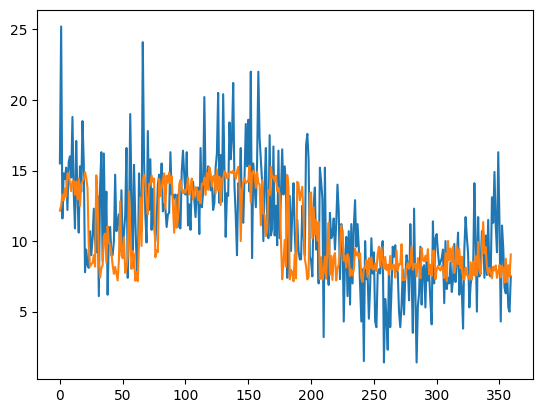

In [36]:
plt.plot(actual)
plt.plot(pred)
plt.show()

In [40]:
err_arr = []
for pair in zip(actual, pred):
    err_arr.append(abs((pair[0] - pair[1])[0]))
print(100*np.mean(err_arr)/np.mean(actual), " % error on average")

24.176083518157967  % error on average
